In [1]:
import os 
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt


from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T

from vision_utils.utils import collate_fn
from vision_utils.engine import train_one_epoch

In [2]:
num_classes = 2 # 0: sudoku 1: not sudoku

In [3]:
def get_model_instance_segmentation(num_classes = 2):
    model = maskrcnn_resnet50_fpn(weights="MaskRCNN_ResNet50_FPN_Weights.COCO_V1").train()
    print("Total Number of trainable parameters with backbone: {total}".format(total = sum([p.numel() for p in model.parameters() if p.requires_grad])))
    backbone_out_feautures = model.roi_heads.mask_predictor.conv5_mask.in_channels
    mask_predictor_hidden_dim = model.roi_heads.mask_predictor.conv5_mask.out_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
            backbone_out_feautures,
            mask_predictor_hidden_dim,
            num_classes
    )
    for param in model.backbone.parameters():
        param.requires_grad = False
    print("Total Number of trainable parameters without backbone: {total}".format(total = sum([p.numel() for p in model.parameters() if p.requires_grad])))
    return model

In [ ]:
class SudokuDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        #target["image_id"] = image_id
        #target["area"] = area
        #target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [6]:
dataset = SudokuDataset(root='./data/original/', transforms=get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn
)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset

print("That's it!")

In [8]:
torch.save({"model": model.state_dict()}, "model.pth")

In [48]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes

def apply_segmentation_mask(model, image, device, threshold=0.7, alpha=0.3):
    model.eval()
    with torch.no_grad():
        eval_transform = get_transform(train=False)
        
        x = eval_transform(image)  # Apply the transformation
        x = x[:3, ...].to(device)  # Convert RGBA -> RGB and move to device
        predictions = model([x, ])
        pred = predictions[0]
    
    # Normalize the image to 0-255 range
    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    image = image[:3, ...]
    
    # Extract masks
    masks = (pred["masks"] > threshold).squeeze(1)
    
    # Apply green color masks with lower opacity
    output_image_mask = draw_segmentation_masks(image, masks, alpha=alpha, colors="green")
    
    # Extract bounding boxes
    pred_boxes = pred["boxes"].long()
    output_image_boxes = draw_bounding_boxes(image, pred_boxes, colors="green", font_size=5, width=5)
    
    return output_image_mask.permute(1, 2, 0), output_image_boxes.permute(1, 2, 0)

In [49]:
image = read_image("data/original/images/1016_1739541260.3697925.jpg")

In [50]:
drawn_mask, drawn_box = apply_segmentation_mask(model, image, device='cpu', alpha=0.7)

c:\Users\RP963AP\OneDrive - EY\Desktop\Sudoku Solver\venv\Lib\site-packages\torchvision\utils.py:233: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


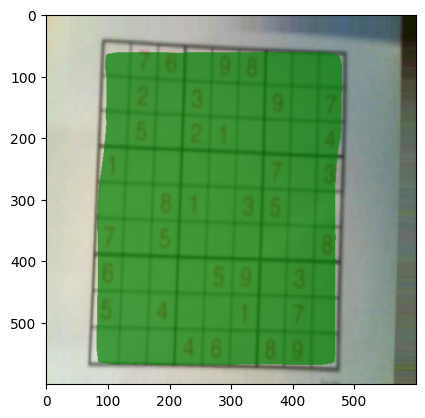

In [51]:
plt.imshow(drawn_mask)

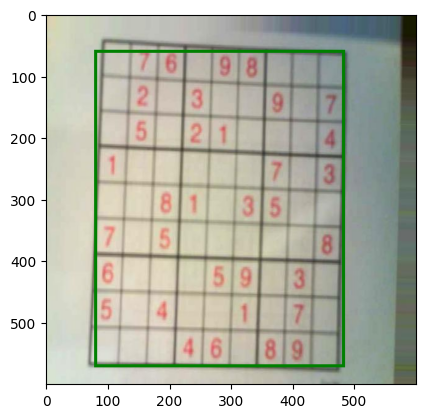

In [52]:
plt.imshow(drawn_box)